Text(0, 0.5, 'Magnitude')

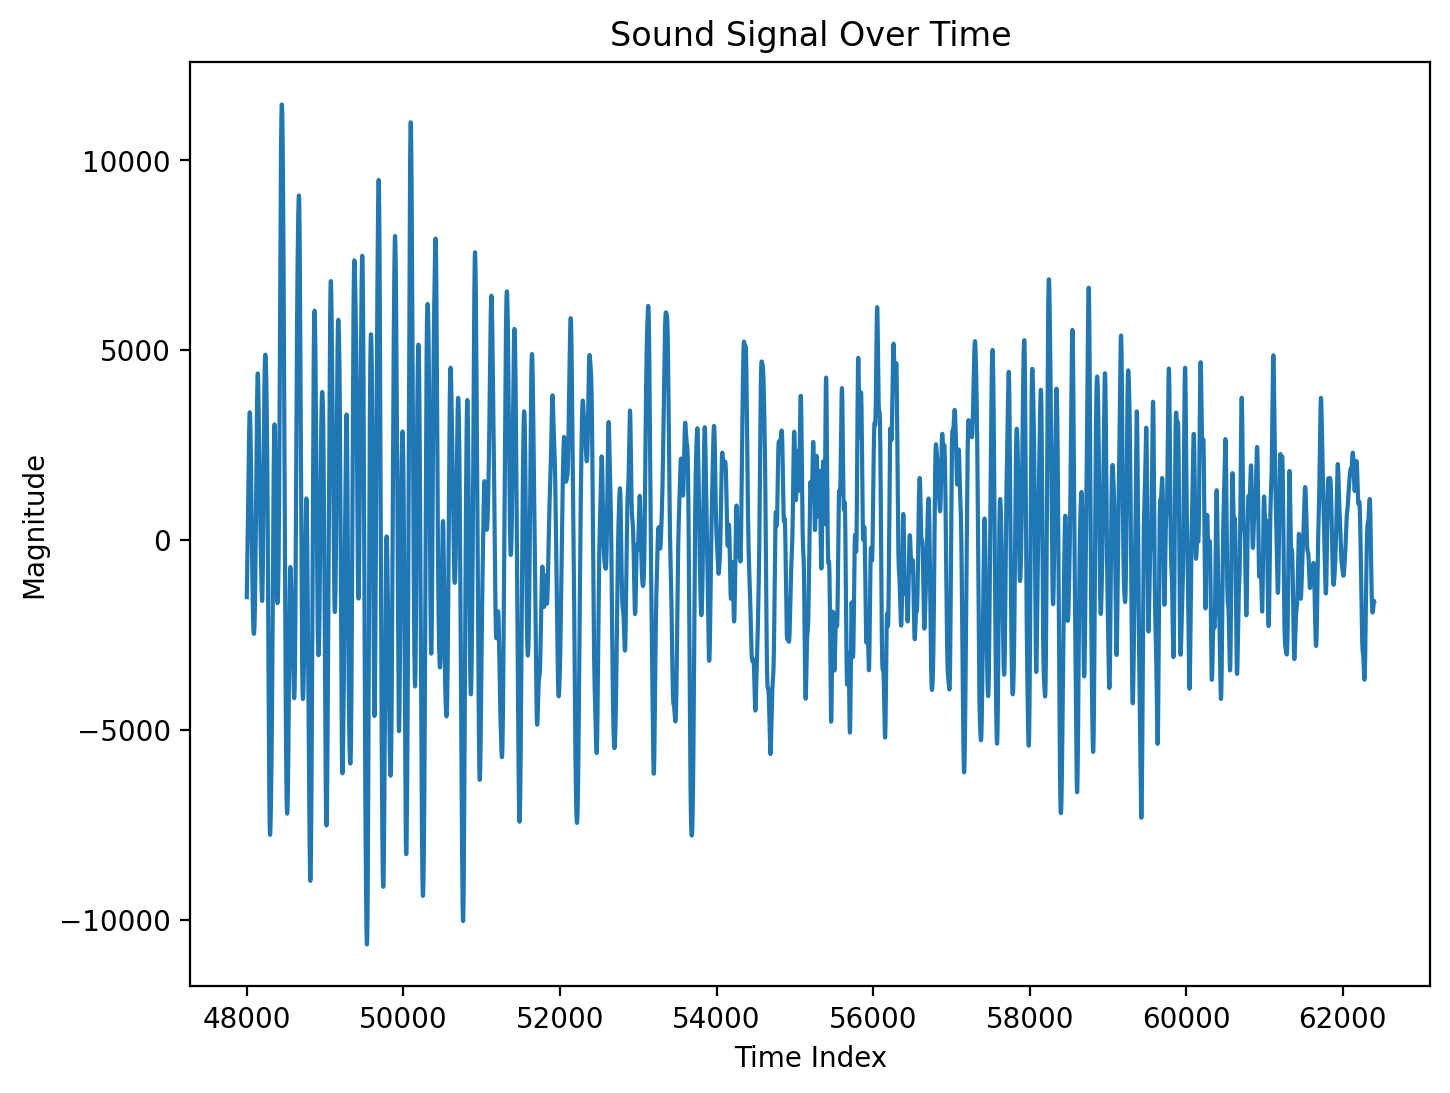

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.dpi'] = 200# 200 e.g. is really fine, but slower
from scipy import fft, signal
import scipy
from scipy.io.wavfile import read

# Read the input WAV files
# Fs is the sampling frequency of the file 
Fs, song = read("data/Richie Campbell - Heartless.wav")
song=song[:,1]
time_to_plot = np.arange(Fs * 1, Fs*1.3, dtype=int) #select the time correspondent to the first sampling frequency
plt.figure()
plt.plot(time_to_plot, song[time_to_plot])
plt.title("Sound Signal Over Time")
plt.xlabel("Time Index")
plt.ylabel("Magnitude")

(7868221,)


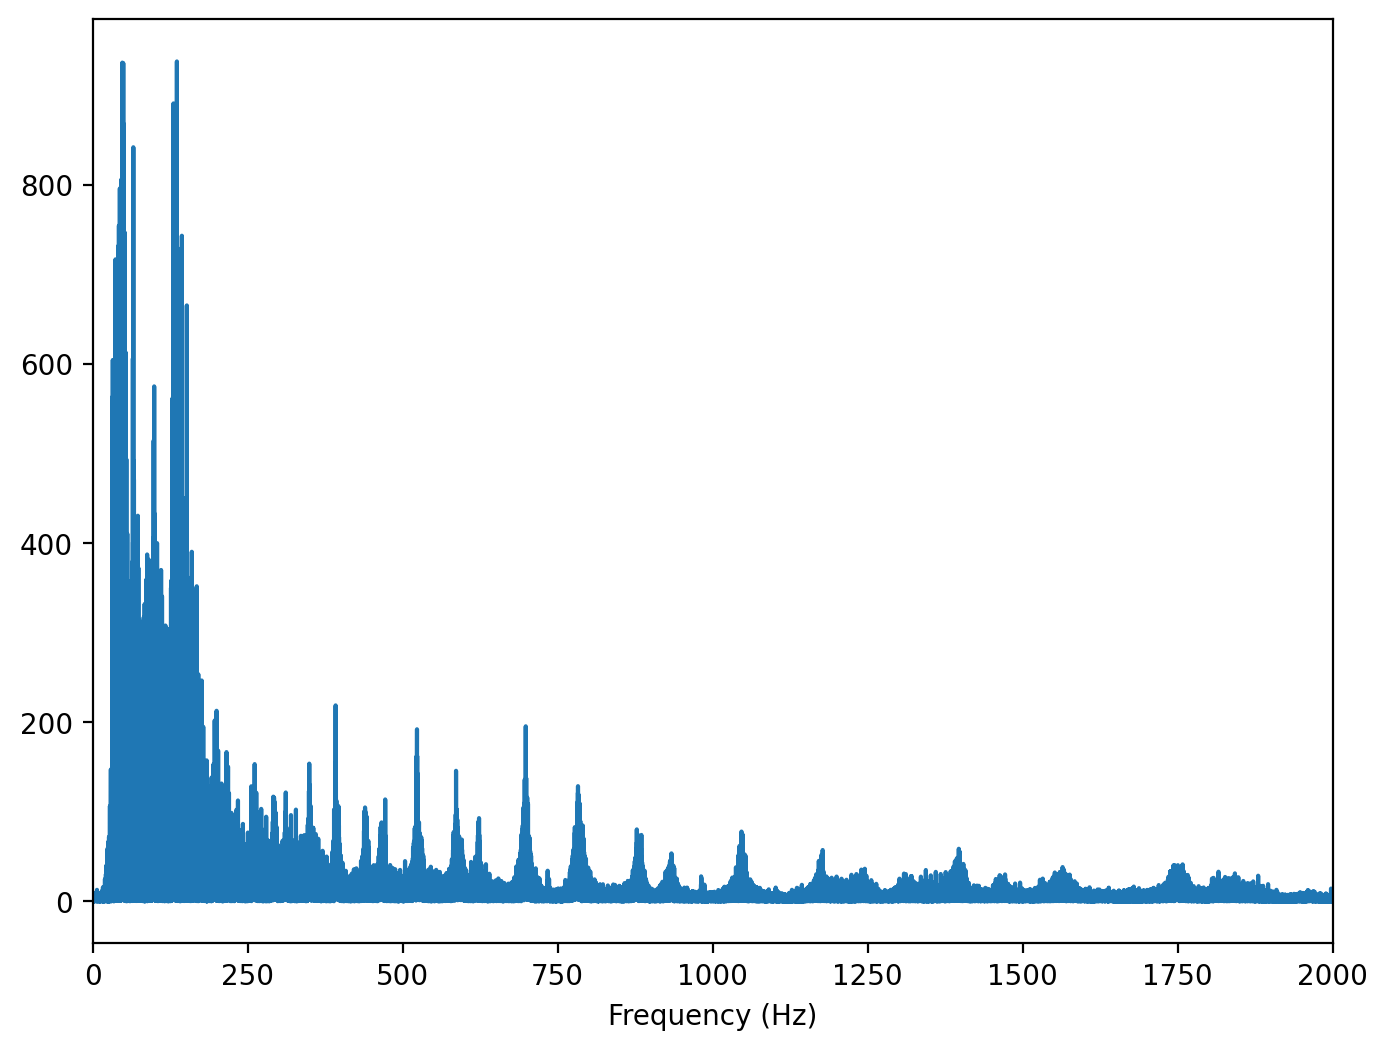

In [2]:
N = len(song)
fft = scipy.fft.fft(song)
print(fft.shape)
transform_y = 2.0 / N * np.abs(fft[0:N//2]) # (2/N) -> amplitude was scaled by 1/N and the negative frequencies were removed
transform_x = scipy.fft.fftfreq(N, 1 / Fs)[:N//2] #only the positive frequencies, the negative are simetric
plt.plot(transform_x, transform_y) 
plt.xlabel("Frequency (Hz)");
plt.xlim(0, 2000);

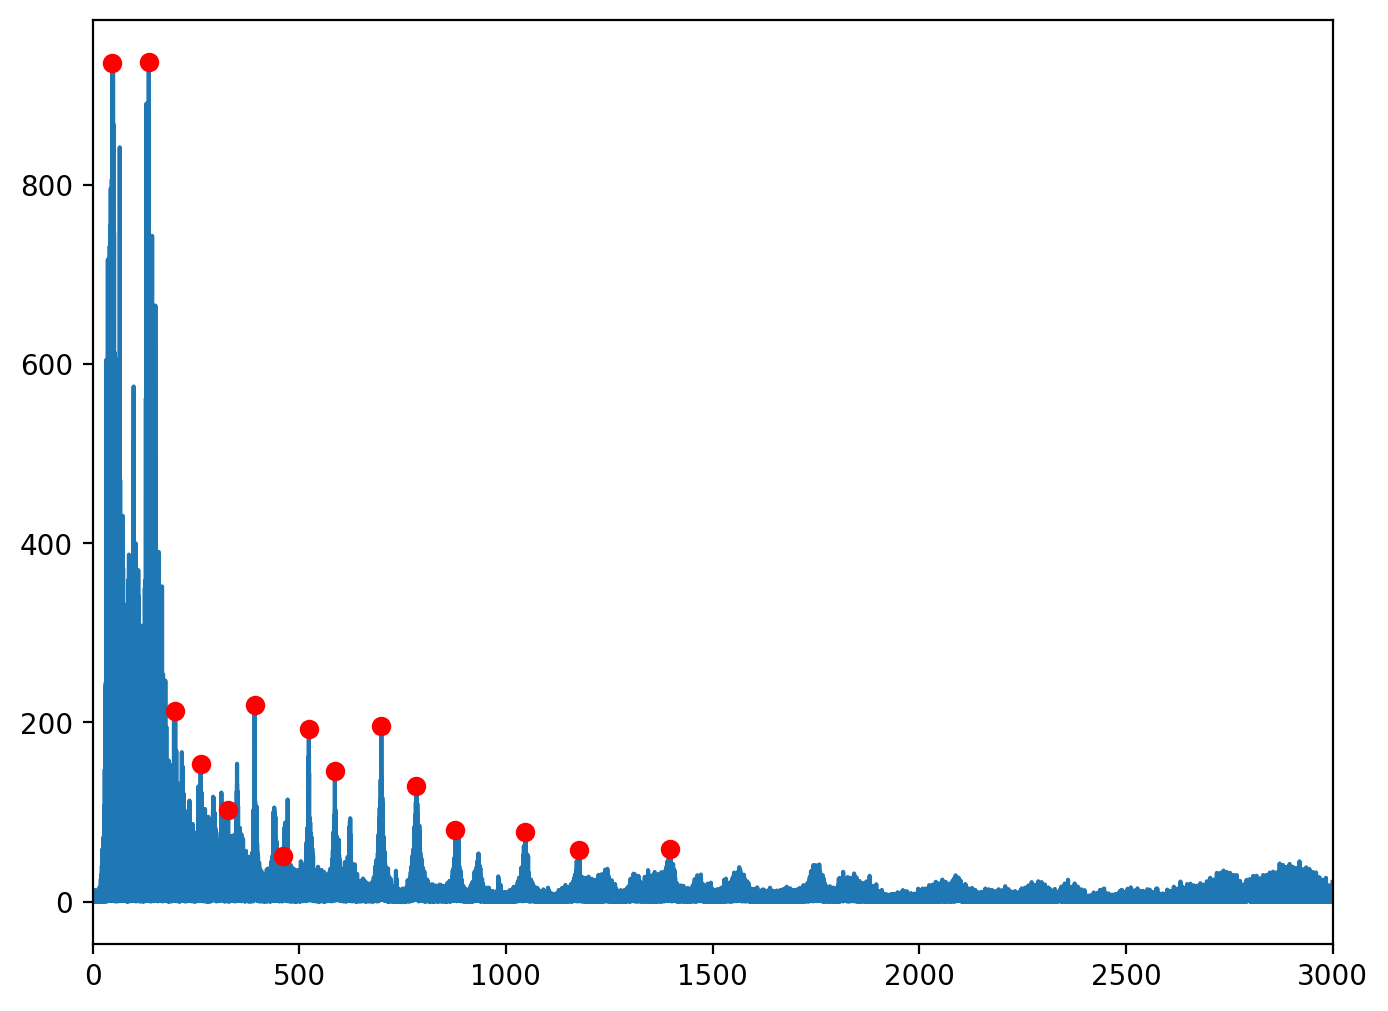

In [3]:

peaks, props = signal.find_peaks(transform_y, prominence=0, distance=10000) #10k Hz translates to 0.25 seconds of distance between peaks
n_peaks = 15

# Get the n_peaks largest peaks from the prominences
# This is an argpartition
# Useful explanation: https://kanoki.org/2020/01/14/find-k-smallest-and-largest-values-and-its-indices-in-a-numpy-array/
largest_peaks_indices = np.argpartition(props["prominences"], -n_peaks)[-n_peaks:] #get the indices of the n_peaks largest peaks
largest_peaks = peaks[largest_peaks_indices]

plt.plot(transform_x, transform_y, label="Spectrum")
plt.scatter(transform_x[largest_peaks], transform_y[largest_peaks], color="r", zorder=10, label="Constrained Peaks")
plt.xlim(0, 3000)

plt.show()


In [4]:
# Some parameters
window_length_seconds = 3
window_length_samples = int(window_length_seconds * Fs)
window_length_samples += window_length_samples % 2

# Perform a short time fourier transformW
# frequencies and times are references for plotting/analysis later
# the stft is a NxM matrix
frequencies, times, stft = signal.stft(
    song, Fs, nperseg=window_length_samples,
    nfft=window_length_samples, return_onesided=True
)

stft.shape

(72001, 111)

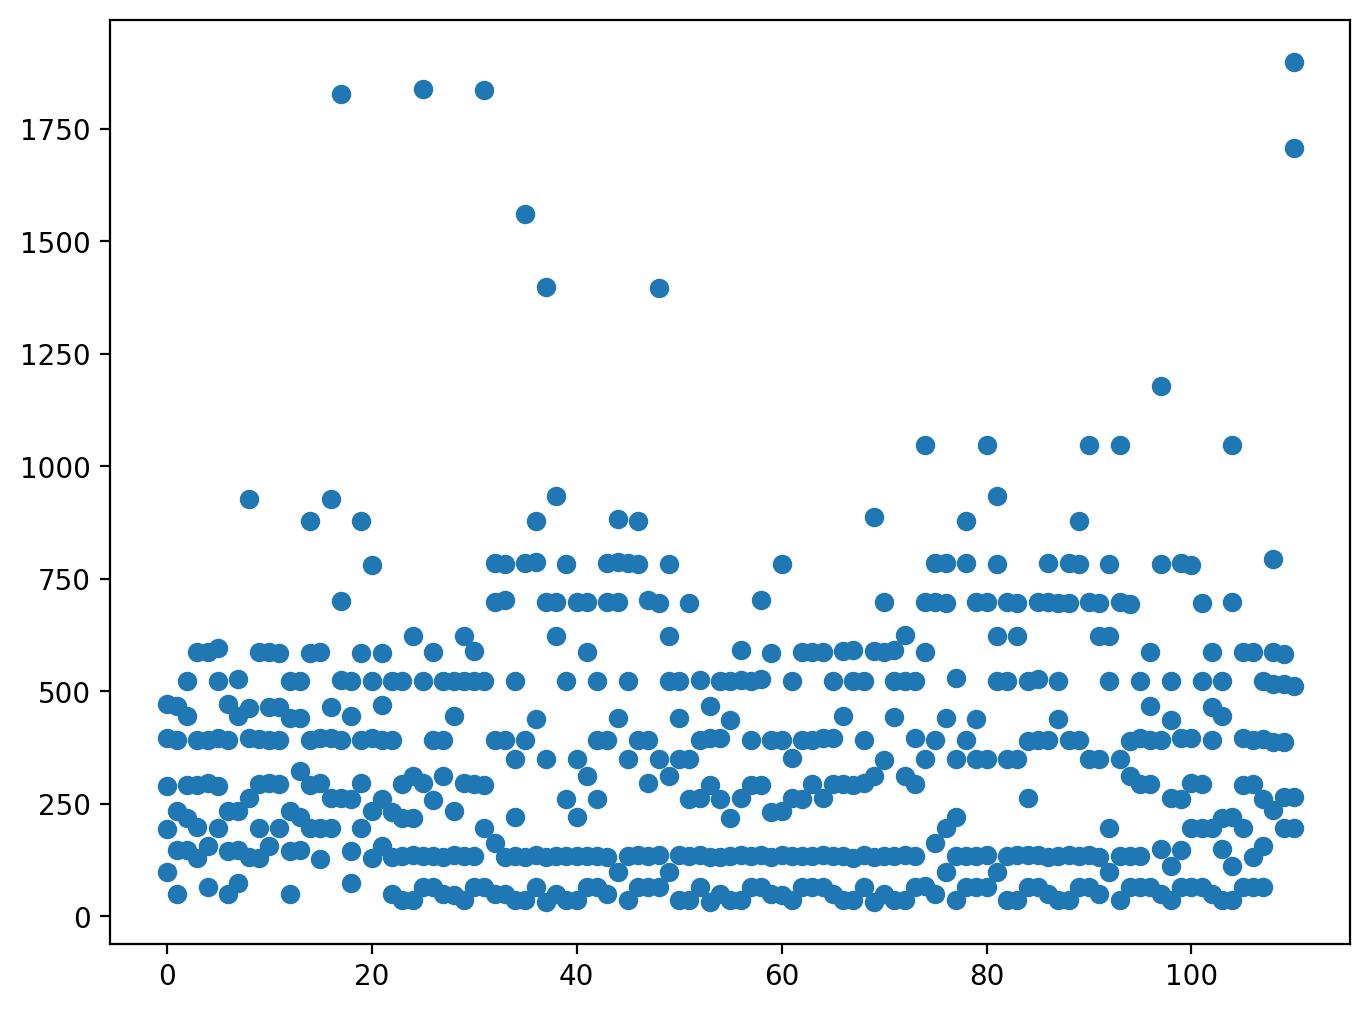

In [5]:
constellation_map = []

for time_idx, window in enumerate(stft.T):
    # Spectrum is by default complex. 
    # We want real values only
    spectrum = abs(window)
    # Find peaks - these correspond to interesting features
    # Note the distance - want an even spread across the spectrum
    peaks, props = signal.find_peaks(spectrum, prominence=0, distance=200)

    # Only want the most prominent peaks
    # With a maximum of 5 per time slice
    n_peaks = 5
    # Get the n_peaks largest peaks from the prominences
    # This is an argpartition
    # Useful explanation: https://kanoki.org/2020/01/14/find-k-smallest-and-largest-values-and-its-indices-in-a-numpy-array/
    largest_peaks = np.argpartition(props["prominences"], -n_peaks)[-n_peaks:]
    for peak in peaks[largest_peaks]:
        frequency = frequencies[peak]
        constellation_map.append([time_idx, frequency])

# Transform [(x, y), ...] into ([x1, x2...], [y1, y2...]) for plotting using zip
plt.scatter(*zip(*constellation_map));

In [14]:
def create_constellation(audio, Fs):
    # Parameters
    window_length_seconds = 0.5
    window_length_samples = int(window_length_seconds * Fs)
    window_length_samples += window_length_samples % 2

    print("Length of the windows:",window_length_samples)
    num_peaks = 15

    # Pad the song to divide evenly into windows
    amount_to_pad = window_length_samples - audio.size % window_length_samples

    song_input = np.pad(audio, (0, amount_to_pad)) #pad with zeros

    # Perform a short time fourier transform
    frequencies, times, stft = signal.stft(
        song_input, Fs, nperseg=window_length_samples, nfft=window_length_samples, return_onesided=True
    )
    #stft.shape = (window_length_samples//2 +1, number_of_windows)
    print(stft.shape)
    constellation_map = []

    for time_idx, window in enumerate(stft.T): 
        # Spectrum is by default complex. 
        # We want real values only
        spectrum = abs(window)
        # Find peaks - these correspond to interesting features
        # Note the distance - want an even spread across the spectrum
        peaks_ind, props = signal.find_peaks(spectrum, prominence=0, distance=200) 
        #24000/200 = 120, 120 points detected as peaks, but only the maxixum 15 will be retrived
        #Return peak indicies and properties

        # Only want the most prominent peaks
        #The prominence of a peak measures how much a peak stands out from the 
        #surrounding baseline of the signal and is defined as the vertical distance 
        #between the peak and its lowest contour line.



        # With a maximum of 15 per time slice
        n_peaks = min(num_peaks, len(peaks_ind))
        # Get the n_peaks largest peaks from the prominences
        # This is an argpartition
        # Useful explanation: https://kanoki.org/2020/01/14/find-k-smallest-and-largest-values-and-its-indices-in-a-numpy-array/
        largest_peaks = np.argpartition(props["prominences"], -n_peaks)[-n_peaks:] #gets the indiced of the n most prominent peaks
        for peak_ind in peaks_ind[largest_peaks]: 
            frequency = frequencies[peak_ind] 
            constellation_map.append([time_idx, frequency]) #add to the map, the time_index and the frequency of the prominent peak

    return constellation_map
#len(constellation_map) ~ 15*number_of_windows 
constellation_map=create_constellation(song, Fs)
constellation_map

Length of the windows: 24000
(12001, 657)


[[0, 6632.0],
 [0, 10576.0],
 [0, 5592.0],
 [0, 13300.0],
 [0, 7894.0],
 [0, 5000.0],
 [0, 536.0],
 [0, 6164.0],
 [0, 3574.0],
 [0, 2942.0],
 [0, 2512.0],
 [0, 2036.0],
 [0, 1576.0],
 [0, 974.0],
 [0, 13764.0],
 [1, 12666.0],
 [1, 7436.0],
 [1, 6430.0],
 [1, 2786.0],
 [1, 5588.0],
 [1, 4816.0],
 [1, 4146.0],
 [1, 3732.0],
 [1, 3260.0],
 [1, 596.0],
 [1, 2382.0],
 [1, 1968.0],
 [1, 1454.0],
 [1, 1018.0],
 [1, 194.0],
 [2, 12878.0],
 [2, 6688.0],
 [2, 8198.0],
 [2, 5778.0],
 [2, 5302.0],
 [2, 4738.0],
 [2, 4106.0],
 [2, 3614.0],
 [2, 3104.0],
 [2, 2626.0],
 [2, 2188.0],
 [2, 1594.0],
 [2, 1168.0],
 [2, 730.0],
 [2, 196.0],
 [3, 8400.0],
 [3, 14846.0],
 [3, 12130.0],
 [3, 6074.0],
 [3, 5622.0],
 [3, 688.0],
 [3, 4970.0],
 [3, 4298.0],
 [3, 3894.0],
 [3, 3362.0],
 [3, 2818.0],
 [3, 2098.0],
 [3, 1588.0],
 [3, 1184.0],
 [3, 232.0],
 [4, 15132.0],
 [4, 10604.0],
 [4, 692.0],
 [4, 6698.0],
 [4, 5966.0],
 [4, 5526.0],
 [4, 4998.0],
 [4, 4188.0],
 [4, 3644.0],
 [4, 3230.0],
 [4, 2768.0],
 [4, 2

[656, 196.0]

In [18]:
constellation_map = create_constellation(song, Fs)

def create_hashes(constellation_map, song_id=None):
    hashes = {}
    # Use this for binning - 23_000 is slighlty higher than the maximum
    # frequency that can be stored in the .wav files, 22.05 kHz
    upper_frequency = 23_000
    frequency_bits = 10
    counter=0

    # Iterate the constellation
    for idx, (time, freq) in enumerate(constellation_map):
        # Iterate the next 100 pairs to produce the combinatorial hashes
        # When we produced the constellation before, it was sorted by time already
        # So this finds the next n points in time (though they might occur at the same time)
        for other_time, other_freq in constellation_map[idx : idx + 100]: 
            diff = other_time - time
            # If the time difference between the pairs is too small or large
            # ignore this set of pairs
            if diff <= 1 or diff > 10:
                counter+=1
                continue

            # Place the frequencies (in Hz) into a 1024 bins
            # Each bin is representing a range of ~22.5, and therefore, there's an error associated. Different frequencies will be mapped to the same bin
            freq_binned = freq / upper_frequency * (2 ** frequency_bits)
            other_freq_binned = other_freq / upper_frequency * (2 ** frequency_bits)

            # Produce a 32 bit hash
            # Use bit shifting to move the bits to the correct location 
            # | is a bitwise OR, but since we shifted the bits, it's like concatenating the bits
            # it is built from left to right, so the first 10 bits are the frequency of the anchor peak
            hash = int(freq_binned) | (int(other_freq_binned) << 10) | (int(diff) << 20)
            hashes[hash] = (time, song_id) # populate the dictionary with the hash as key and the time and song_id as value
    print(counter)
    return hashes

# Quickly investigate some of the hashes produced
hashes = create_hashes(constellation_map, song_id=1)
for i, (hash, (time, song_id)) in enumerate(hashes.items()):
    if i > 10: 
        break
    print(f"Hash {hash} occurred at {time} in song {song_id}")

Length of the windows: 24000
(12001, 657)
226440
Hash 2684199 occurred at 0 in song 1
Hash 2401575 occurred at 0 in song 1
Hash 2470183 occurred at 527 in song 1
Hash 2360615 occurred at 0 in song 1
Hash 2339111 occurred at 0 in song 1
Hash 2312487 occurred at 125 in song 1
Hash 2283815 occurred at 0 in song 1
Hash 2261287 occurred at 25 in song 1
Hash 2238759 occurred at 497 in song 1
Hash 2216231 occurred at 372 in song 1
Hash 2196775 occurred at 482 in song 1


In [20]:
import glob
from typing import List, Dict, Tuple
from tqdm import tqdm
import pickle

songs = glob.glob('data/*.wav')

song_name_index = {}
database: Dict[int, List[Tuple[int, int]]] = {}

# Go through each song, using where they are alphabetically as an id
for index, filename in enumerate(tqdm(sorted(songs))):
    song_name_index[index] = filename
    # Read the song, create a constellation and hashes
    Fs, audio_input = read(filename)
    constellation = create_constellation(audio_input[:,0], Fs)
    hashes = create_hashes(constellation, index)

    # For each hash, append it to the list for this hash
    for hash, time_index_pair in hashes.items():
        if hash not in database:
            database[hash] = []
        database[hash].append(time_index_pair)
# Dump the database and list of songs as pickles
with open("database.pickle", 'wb') as db:
    pickle.dump(database, db, pickle.HIGHEST_PROTOCOL)
with open("song_index.pickle", 'wb') as songs:
    pickle.dump(song_name_index, songs, pickle.HIGHEST_PROTOCOL)

  0%|          | 0/2 [00:00<?, ?it/s]

Length of the windows: 24000
(12001, 571)
193665


 50%|█████     | 1/2 [00:04<00:04,  4.12s/it]

Length of the windows: 24000
(12001, 657)
226440


100%|██████████| 2/2 [00:08<00:00,  4.30s/it]


In [21]:
# Load the database
database = pickle.load(open('database.pickle', 'rb'))
song_name_index = pickle.load(open("song_index.pickle", "rb"))

In [26]:
Fs, audio_input = read("recording1.wav")
# Create the constellation and hashes
constellation = create_constellation(audio_input, Fs)
hashes = create_hashes(constellation, None)

# For each hash in the song, check if there's a match in the database
# There could be multiple matching tracks, so for each match:
#   Incrememnt a counter for that song ID by one
matches_per_song = {}
for hash, (sample_time, _) in hashes.items():
    if hash in database:
        matching_occurences = database[hash]
        for source_time, song_id in matching_occurences:
            if song_id not in matches_per_song:
                matches_per_song[song_id] = 0
            matches_per_song[song_id] += 1

for song_id, num_matches in list(sorted(matches_per_song.items(), key=lambda x: x[1], reverse=True))[:10]:
    print(f"Song: {song_name_index[song_id]} - Matches: {num_matches}")

Length of the windows: 24000
(12001, 59)
19785
Song: data\24kGoldn - Mood ft. iann dior.wav - Matches: 30192
Song: data\Richie Campbell - Heartless.wav - Matches: 23329


In [28]:
# Load a short recording with some background noise
Fs, audio_input = read("recording2.wav")
# Create the constellation and hashes
constellation = create_constellation(audio_input, Fs)
hashes = create_hashes(constellation, None)

# For each hash in the song, check if there's a match in the database
# There could be multiple matches, so for each match:
#   Append all of them to a hashmap based on the song id along with the time
#   the hash occurs in the sample and at the source
# In the end, matches_per_song is key'd by song ID with values being
# lists of hashes, the 
matches_per_song = {}
for hash, (sample_time, _) in hashes.items():
    if hash in database:
        matching_occurences = database[hash]
        for source_time, song_id in matching_occurences:
            if song_id not in matches_per_song:
                matches_per_song[song_id] = []
            matches_per_song[song_id].append((hash, sample_time, source_time))
matches_per_song

Length of the windows: 24000
(12001, 47)
15645


{0: [(2330847, 0, 231),
  (2415839, 0, 231),
  (2287839, 0, 428),
  (2245855, 0, 231),
  (2202847, 0, 132),
  (2160863, 0, 428),
  (2108639, 0, 20),
  (3241183, 0, 428),
  (3284191, 0, 231),
  (3262687, 0, 231),
  (3180767, 0, 428),
  (3157215, 0, 20),
  (4218079, 0, 273),
  (4278495, 0, 273),
  (4241631, 0, 273),
  (5386463, 0, 273),
  (5328095, 0, 132),
  (5290207, 0, 246),
  (5266655, 0, 273),
  (6707423, 0, 428),
  (6639839, 0, 132),
  (2330987, 0, 21),
  (2480491, 0, 250),
  (2309483, 0, 234),
  (2202987, 0, 234),
  (2224491, 0, 21),
  (2132331, 0, 444),
  (2108779, 0, 21),
  (3241323, 0, 445),
  (3157355, 0, 21),
  (4535659, 0, 250),
  (4218219, 0, 233),
  (5457259, 0, 21),
  (6615403, 0, 445),
  (6453611, 0, 233),
  (2415919, 0, 248),
  (2309423, 0, 155),
  (2287919, 0, 474),
  (2267439, 0, 550),
  (2245935, 0, 243),
  (2202927, 20, 514),
  (2224431, 23, 514),
  (2182447, 0, 550),
  (2132271, 16, 306),
  (2160943, 23, 410),
  (2108719, 27, 504),
  (3489071, 16, 337),
  (3348783,

Total matches for  Heartless.wav: 19178
Total matches for  Mood ft. iann dior.wav: 21783


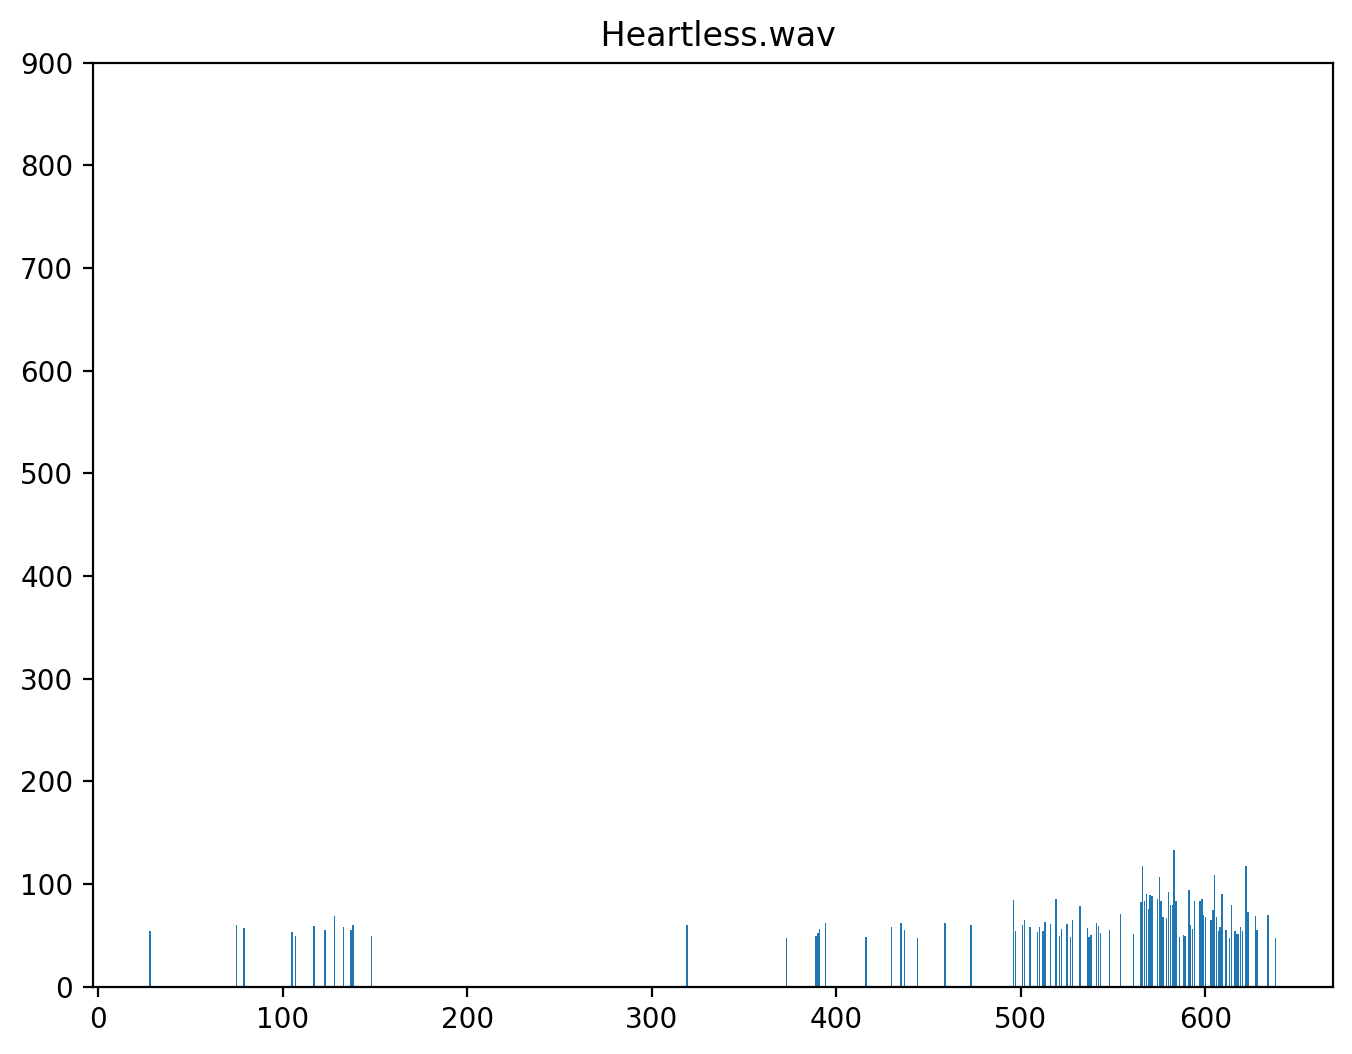

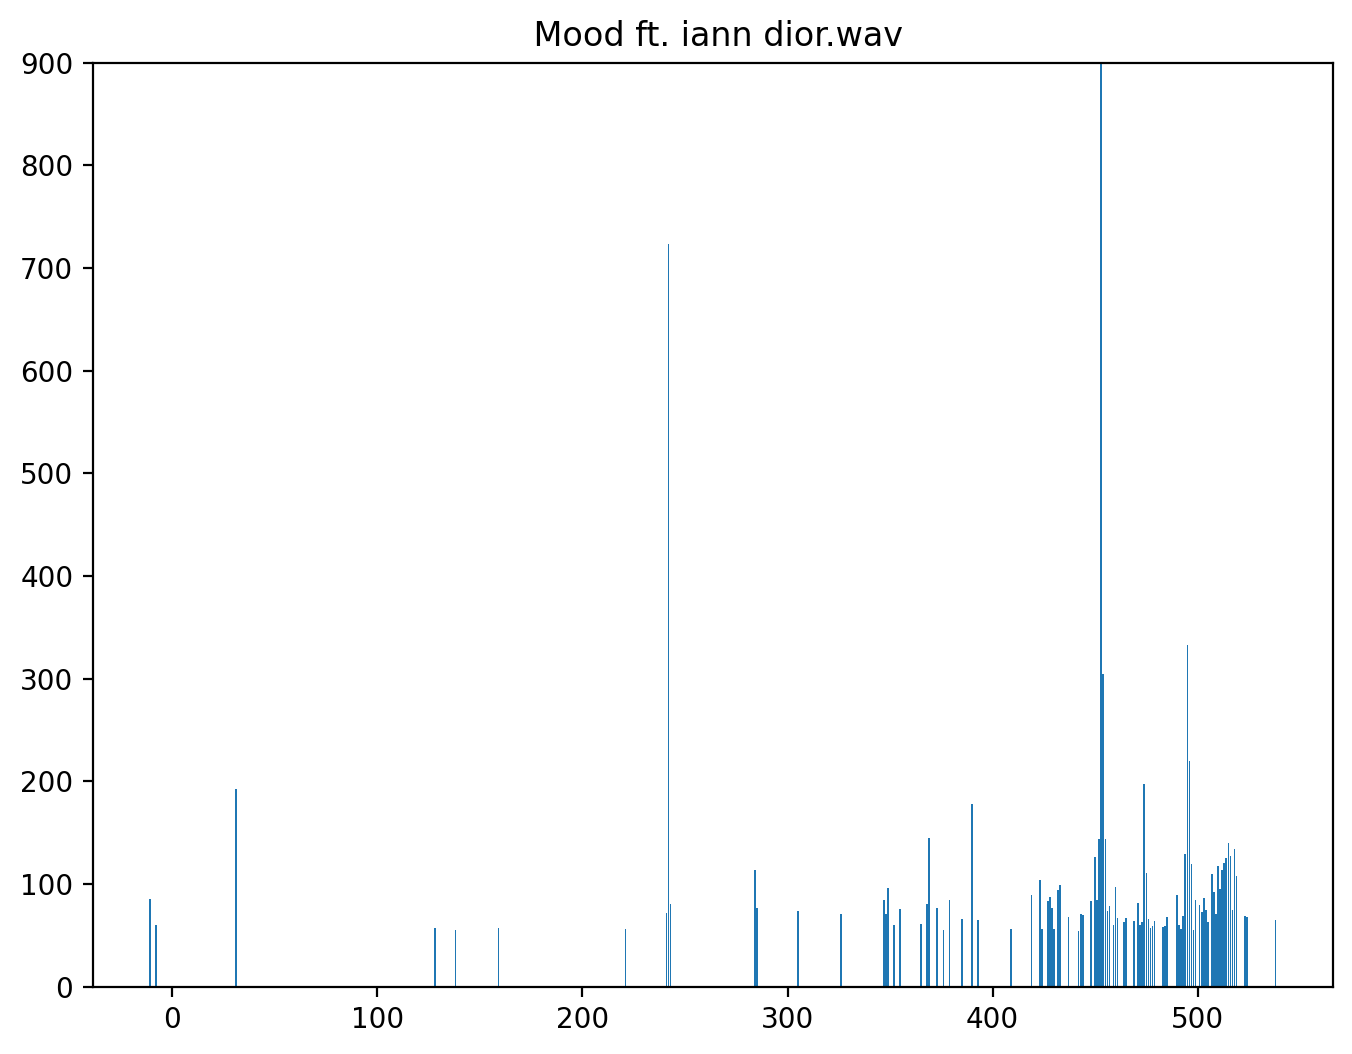

In [30]:
scores = {}
song_ids = [1, 0] # Song ID=0 is the true match
for song_id in song_ids:
    song_name = song_name_index[song_id].split('-')[1]

    matches = matches_per_song[song_id]
    print(f"Total matches for {song_name}: {len(matches)}")
    song_scores_by_offset = {}
    for hash, sample_time, source_time in matches:
        delta = source_time - sample_time
        if delta not in song_scores_by_offset:
            song_scores_by_offset[delta] = 0
        song_scores_by_offset[delta] += 1 #how many matches with a certain difference between the time of the sample and the time of the source

    # Produce a histogram
    # For clarity's sake, only plot the 100 largest offsets
    high_scores = list(sorted(song_scores_by_offset.items(), key=lambda x: x[1], reverse=True))[:100]
    plt.figure()
    plt.bar(*zip(*high_scores))
    plt.title(song_name)
    plt.ylim((0, 900))

In [37]:
scores = {}
for song_index, matches in matches_per_song.items():
    song_scores_by_offset = {}
    for hash, sample_time, source_time in matches:
        delta = source_time - sample_time
        if delta not in song_scores_by_offset:
            song_scores_by_offset[delta] = 0
        song_scores_by_offset[delta] += 1

    max = (0, 0) 
    for offset, score in song_scores_by_offset.items():
        if score > max[1]:
            max = (offset, score)
    
    scores[song_index] = max

for song_index, score in list(sorted(scores.items(), key=lambda x: x[1][1], reverse=True))[:5]:
    print(f"{song_name_index[song_index]}: Score of {score[1]} with a time difference of {score[0]}")

data\24kGoldn - Mood ft. iann dior.wav: Score of 913 with a time difference of 453
data\Richie Campbell - Heartless.wav: Score of 133 with a time difference of 583


In [38]:
def score_hashes_against_database(hashes):
    matches_per_song = {}
    for hash, (sample_time, _) in hashes.items():
        if hash in database:
            matching_occurences = database[hash]
            for source_time, song_index in matching_occurences:
                if song_index not in matches_per_song:
                    matches_per_song[song_index] = []
                matches_per_song[song_index].append((hash, sample_time, source_time))
            

    # %%
    scores = {}
    for song_index, matches in matches_per_song.items():
        song_scores_by_offset = {}
        for hash, sample_time, source_time in matches:
            delta = source_time - sample_time
            if delta not in song_scores_by_offset:
                song_scores_by_offset[delta] = 0
            song_scores_by_offset[delta] += 1

        max = (0, 0)
        for offset, score in song_scores_by_offset.items():
            if score > max[1]:
                max = (offset, score)
        
        scores[song_index] = max

    # Sort the scores for the user
    scores = list(sorted(scores.items(), key=lambda x: x[1][1], reverse=True)) 
    
    return scores

In [39]:
def print_top_five(file_name):
    # Load a short recording with some background noise
    Fs, audio_input = read(file_name)
    # Create the constellation and hashes
    constellation = create_constellation(audio_input, Fs)
    hashes = create_hashes(constellation, None)

    scores = score_hashes_against_database(hashes)[:5]
    for song_id, score in scores:
        print(f"{song_name_index[song_id]}: Score of {score[1]} at {score[0]}")

print("Recording 1:")
print_top_five("recording1.wav")

print("\n\nRecording 2:")
print_top_five("recording2.wav")

Recording 1:
Length of the windows: 24000
(12001, 59)
19785
data\24kGoldn - Mood ft. iann dior.wav: Score of 862 at 142
data\Richie Campbell - Heartless.wav: Score of 139 at 590


Recording 2:
Length of the windows: 24000
(12001, 47)
15645
data\24kGoldn - Mood ft. iann dior.wav: Score of 913 at 453
data\Richie Campbell - Heartless.wav: Score of 133 at 583
